# Traveltime tomography

In this fifth lab of the *ErSE 210 - Seismology* course, we will look at traveltime tomography. This is a very popular technique in geoscience and other related fields (e.g., optical and medical imaging).

To begin with let's define the forward model of the tomographic problem:

$$
t = \int_l s(l) dl \qquad\qquad\qquad (1)
$$

where $s=1/c$ is the slowness of the medium ($c$ is the velocity of the medium) that is integrated over the raypath (indicated with $l$) to give the traveltime $t$ associated with this ray. To be able to numerically work with this integral relation, we have to discretize it. In other words, we can define a regular grid and rewrite our modelling equation as:

$$
t = \sum_i s[i] l[i] \qquad\qquad\qquad (2)
$$

where $i$ is the index of the grid point that the ray travels within, whilst $s[i]$ and $l[i]$ are the associated slowness of this grid point and lenght of the ray as depicted in the figure below (Source: *P.Shearer, Introduction to Seismology, 3rd Edition*)

![Rays](rays.jpg)

We are going to break down the problem in three components:

- Compute rays from sources and receivers
- Evaluate the lenght of each of these rays within a regular grid to compute the tomographic matrix
- Invert the tomographic matrix

The first and second steps are fairly straighforward especially under the assumption of *straigh rays* which we will be using here. The last step is the most interesting one, however it requires some basic knowledge of Inverse Problems that is not a prerequisite for this course. We will try to fill the gaps and provide a simple, intuitive introduction to tomographic inversion and how this can be easily done in Python with libraries such as [SciPy](https://www.scipy.org).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from math import sqrt
from scipy.sparse.linalg import lsqr
from skimage.draw import polygon, disk, ellipse
from scipy.sparse import csc_matrix

from raytrace import raytrace, straigh_ray, straigh_rays, tomographic_matrix

np.random.seed(0)

## Single ray creation

To begin with we are going to consider a single generic ray in a homogenous and compute its associated tomographic matrix. 

We can also compare the numerically estimated traveltime from the computed tomographic matrix with the analytical espression.

In [2]:
# Grid specification
nx, nz = 21, 21
ox, oz = 0., 0.
dx, dz = 10., 10.
x = ox + dx * np.arange(nx) + dx/2
z = oz + dz * np.arange(nz) + dz/2

# Model
vback = 1000
vel = vback * np.ones((nx, nz))

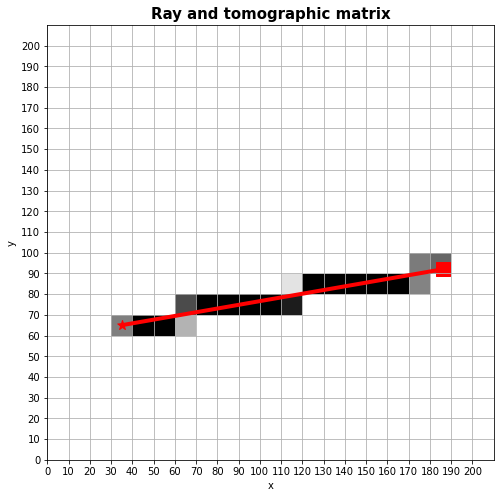

In [3]:
# Source and receiver
s = [35, 65]
r = [186, 92]

# Find analytical expression of straigt line
rayx, rayz = straigh_ray(s, r)

# Compute tomographic matrix
L, c, v = raytrace(s, r, dx, dz, ox, oz, nx, nz, x, z)

plt.figure(figsize=(8, 8))
plt.imshow(L.reshape(nx, nz).T, origin='lower', cmap='gray_r',
           extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
plt.scatter(s[0], s[1], c='r', s=100, marker='*')
plt.scatter(r[0], r[1], c='r', s=200, marker='s')
plt.plot(rayx, rayz, c='r', lw=4)
plt.xticks(x-dx//2)
plt.yticks(z-dx//2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ray and tomographic matrix', fontsize=15, fontweight='bold')
plt.grid('on', which='both')
plt.axis('tight');

Let's now validate that what we have obtained is correct. By summing the values in each of the cells we can obtain the lenght of the segment and compare it with the analytical expression for it (we can also divide both of them by the velocity of the medium and compare the traveltimes)

In [4]:
# Create slowness model and compute traveltime from equation 2
slown = (1. / vel).ravel()
trav = L.reshape(1, -1) @ slown

# Analytical traveltime
trav_ana =  sqrt((s[0]-r[0])**2 + (s[1]-r[1])**2) / vback

print(f'Numerical traveltime {trav[0]}, Analytical traveltime: {trav_ana}')

Numerical traveltime 0.15339491516996245, Analytical traveltime: 0.15339491516996254


Finally, let's see how we can use the $v$ and $c$ outputs from our `raytrace` routine to create a sparse matrix that is equivalent to `R` and can be used later on for inversion.

Without going into the details of sparse matrices, this is an ideal scenario for using such matrices as each ray can be easily identified by a set of triplets $(r,c,v)$ where $r$ refers to the row index (index of ray), $c$ refers to the column index (index of grid cell), and $v$ is the lenght of the ray in the cell.

In [5]:
L1 = csc_matrix((v, (np.zeros_like(c), c)), shape=(1, nx*nz))
print(f'Equivalence of tomographic matrices: {np.allclose(L1.todense(), L)}')

Equivalence of tomographic matrices: True


## Multiple rays

Let's move on now considering multiple rays. First we consider a single source and multiple receivers.

In [6]:
# Source
ns = 1
s = np.array([35, 65])[:, np.newaxis]

# Receivers
nr = 40
r = np.empty((2, nr))
r[0] = 186
r[1] = np.arange(nr)*4 + 35

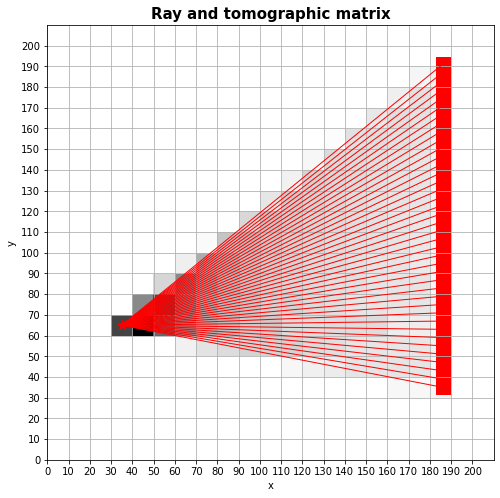

In [7]:
# Tomographic matrix and rays
L = tomographic_matrix(s, r, dx, dz, ox, oz, nx, nz, x, z)
rays = straigh_rays(s, r)

plt.figure(figsize=(8, 8))
plt.imshow(np.sum(np.array(L.todense()).reshape(ns*nr, nx, nz), axis=0).T, 
           origin='lower', cmap='gray_r',
           extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
plt.scatter(s[0], s[1], c='r', s=100, marker='*')
plt.scatter(r[0], r[1], c='r', s=200, marker='s')
for ray in rays:
    plt.plot(ray[0], ray[1], c='r', lw=1)
plt.xticks(x-dx//2)
plt.yticks(z-dx//2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ray and tomographic matrix', fontsize=15, fontweight='bold')
plt.grid('on', which='both')
plt.axis('tight');

Finally once again we can compare the analytical and numerical traveltimes

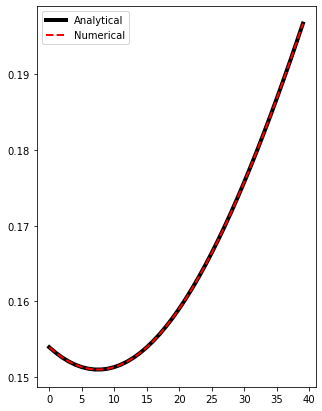

In [8]:
# Create slowness model and compute traveltime from equation 2
slown = (1. / vel).ravel()
trav = np.array(L.todense()) @ slown

# Analytical traveltime
trav_ana = np.zeros(nr)
for irec in range(nr):
    trav_ana[irec] =  sqrt((s[0]-r[0, irec])**2 + (s[1]-r[1, irec])**2) / vback
    
plt.figure(figsize=(5, 7))
plt.plot(trav_ana, 'k', lw=4, label='Analytical')
plt.plot(trav, '--r', lw=2, label='Numerical')
plt.legend();

Finally, we are in a position to define a multi-source, multi-receiver geometry.

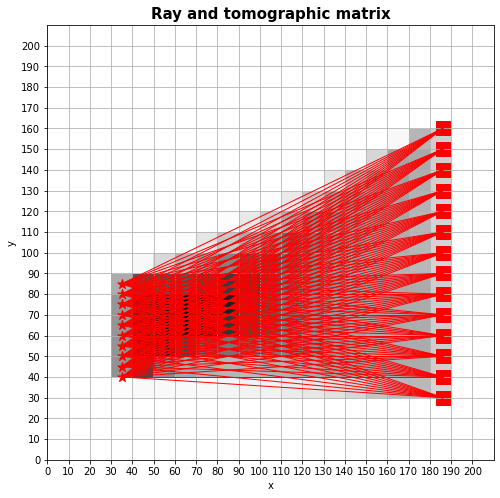

In [9]:
# Sources
ns = 10
s = np.empty((2, ns))
s[0] = 35
s[1] = np.arange(ns)*5 + 40

# Receivers
nr = 14
r = np.empty((2, nr))
r[0] = 186
r[1] = np.arange(nr)*10 + 30

# Tomographic matrix and rays
L = tomographic_matrix(s, r, dx, dz, ox, oz, nx, nz, x, z)
rays = straigh_rays(s, r)

plt.figure(figsize=(8, 8))
plt.imshow(np.sum(np.array(L.todense()).reshape(ns*nr, nx, nz), axis=0).T, 
           origin='lower', cmap='gray_r',
           extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
plt.scatter(s[0], s[1], c='r', s=100, marker='*')
plt.scatter(r[0], r[1], c='r', s=200, marker='s')
for ray in rays:
    plt.plot(ray[0], ray[1], c='r', lw=1)
plt.xticks(x-dx//2)
plt.yticks(z-dx//2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ray and tomographic matrix', fontsize=15, fontweight='bold')
plt.grid('on', which='both')
plt.axis('tight');

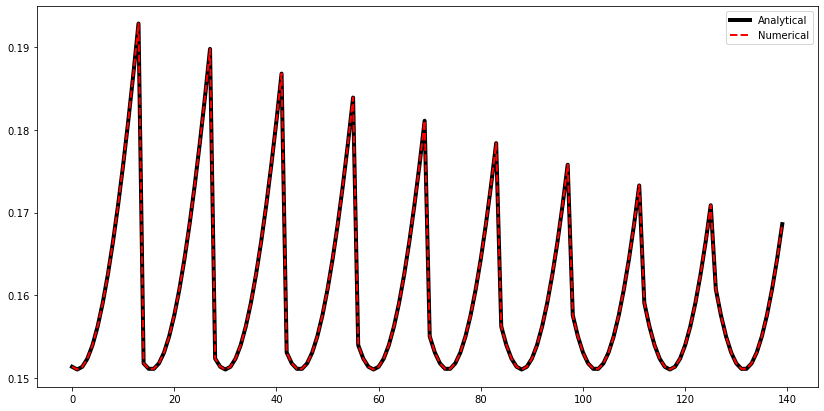

In [10]:
# Create slowness model and compute traveltime from equation 2
slown = (1. / vel).ravel()
trav = np.array(L.todense()) @ slown

# Analytical traveltime
trav_ana = np.zeros((ns, nr))
for isrc in range(ns):
    for irec in range(nr):
        trav_ana[isrc, irec] = sqrt((s[0, isrc]-r[0, irec])**2 + (s[1, isrc]-r[1, irec])**2) / vback

plt.figure(figsize=(14, 7))
plt.plot(trav_ana.ravel(), 'k', lw=4, label='Analytical')
plt.plot(trav, '--r', lw=2, label='Numerical')
plt.legend();

## Tomographic inversion

Now that we have learned out to create a geometry with multiple sources and receivers and their associated tomographic matrix, we are ready to focus our attention on the final task: tomographic inversion. 

Here we reformulate the forward problem in equation 2 in a compact matrix-vector notation:

$$
\textbf{t} = \textbf{L} \textbf{s} \qquad\qquad\qquad (3)
$$

and try to solve this system of equations (i.e., invert the matrix $\textbf{L}$) by means of an iterative solver. In this case we use the popular `LSQR` solver available in SciPy.

First of all, let's define an heterogenous model

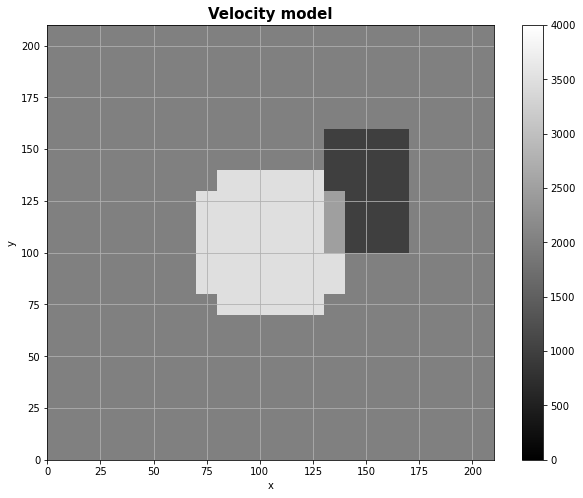

In [11]:
# Model
vback = 2000
vel = vback * np.ones((nx, nz))
rr, cc = disk((nx//2, nz//2), radius=4, shape=vel.shape)
vel[rr, cc] = 3500
rr, cc = polygon([13, 16, 16, 13], [10, 10, 15, 15], shape=vel.shape)
vel[rr, cc] -= 1000

plt.figure(figsize=(10, 8))
plt.imshow(vel.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
           extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity model', fontsize=15, fontweight='bold')
plt.colorbar()
plt.grid('on', which='both')
plt.axis('tight');

Let's now define our acquisition geometry. We have 4 different cases, you can play with all of them and investigate the impact that the acquisition has on our ability to retrieve the velocity model from the observed traveltimes

In [12]:
geometry = 'Surrounded' # Possible choices: Crosshole, VSP, Surrounded

/Users/ravasim/Desktop/KAUST/Teaching/Seismology/Exercises/SeismicTomography/raytrace.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  m = (r[1] - s[1]) / (r[0] - s[0])
/Users/ravasim/Desktop/KAUST/Teaching/Seismology/Exercises/SeismicTomography/raytrace.py:237: RuntimeWarning: invalid value encountered in add
  rayz = rayx * m + q


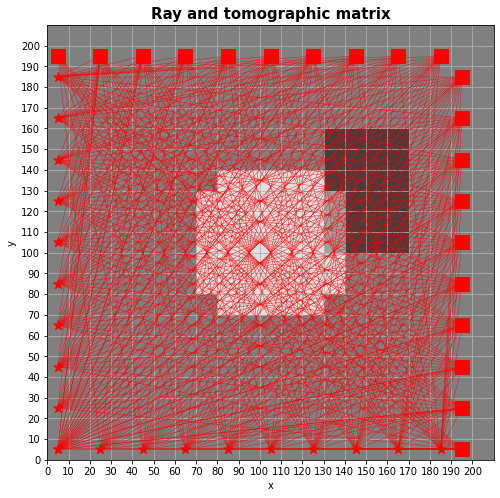

In [13]:
ns = 20
nr = 20
s = np.empty((2, ns))
r = np.empty((2, nr))

if geometry == 'Crosshole':
    #Crosshole
    s[0,:ns] = 5
    s[1,:ns] = np.arange(ns)*10 + 5
    r[0,:nr] = 195
    r[1,:nr] = np.arange(nr)*10 + 5
elif geometry == 'VSP':
    s[0,:ns] = np.arange(ns)*10 + 7.5
    s[1,:ns] = 197.5
    r[0,:nr] = 102.5
    r[1,:nr] = np.arange(nr)*10 + 2.5
elif geometry == 'Surrounded':
    s[0,:ns//2] = 5
    s[1,:ns//2] = np.arange(ns//2)*20 + 5
    r[0,:nr//2] = 195
    r[1,:nr//2] = np.arange(nr//2)*20 + 5

    s[1,ns//2:] = 5
    s[0,ns//2:] = np.arange(ns//2)*20 + 5
    r[1,nr//2:] = 195
    r[0,nr//2:] = np.arange(nr//2)*20 + 5

# Compute rays
rays = straigh_rays(s, r)

plt.figure(figsize=(8, 8))
plt.imshow(vel.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
           extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
plt.scatter(s[0], s[1], c='r', s=100, marker='*')
plt.scatter(r[0], r[1], c='r', s=200, marker='s')
for ray in rays:
    plt.plot(ray[0], ray[1], c='r', lw=0.4)
plt.xticks(x-dx//2)
plt.yticks(z-dx//2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ray and tomographic matrix', fontsize=15, fontweight='bold')
plt.grid('on', which='both')
plt.axis('tight');

And we construct our tomographic matrix

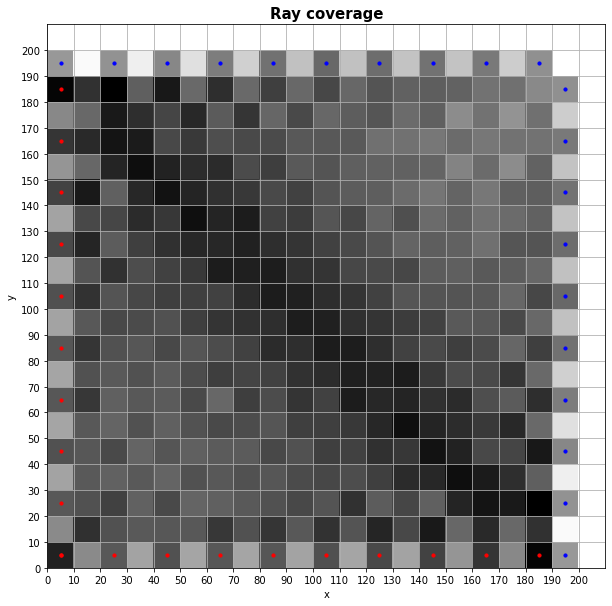

In [14]:
# Tomographic matrix
L = tomographic_matrix(s, r, dx, dz, ox, oz, nx, nz, x, z)

plt.figure(figsize=(10, 10))
plt.imshow(np.sum(np.array(L.todense()).reshape(ns*nr, nx, nz), axis=0).T, 
           origin='lower', cmap='gray_r',
           extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
plt.scatter(s[0], s[1], c='r', s=10)
plt.scatter(r[0], r[1], c='b', s=10);plt.xlabel('x')
plt.xticks(x-dx//2)
plt.yticks(z-dx//2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ray coverage', fontsize=15, fontweight='bold')
plt.grid('on', which='both')
plt.axis('tight');

In [15]:
# Tomographic matrix
L

<400x441 sparse matrix of type '<class 'numpy.float64'>'
	with 9320 stored elements in Compressed Sparse Column format>

## Noise free inversion

We are finally ready to perform our first inversion. We will start with noise free data to investigate the possibly ill-posed nature of the problem we are dealing with. 

In other words, when noise free data are available a well-posed operator can be inverted exactly giving us the correct underlying model. This is not the case for operators that are ill-posed (one or more zero eigenvalues). This is (almost) always the case for our tomographic problem.

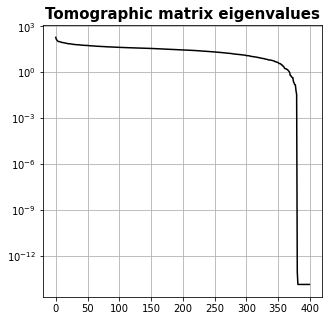

In [16]:
plt.figure(figsize=(5, 5))
plt.semilogy(np.linalg.svd(np.array(L.todense()))[1], 'k')
plt.title('Tomographic matrix eigenvalues', fontsize=15, fontweight='bold')
plt.grid('on', which='both')

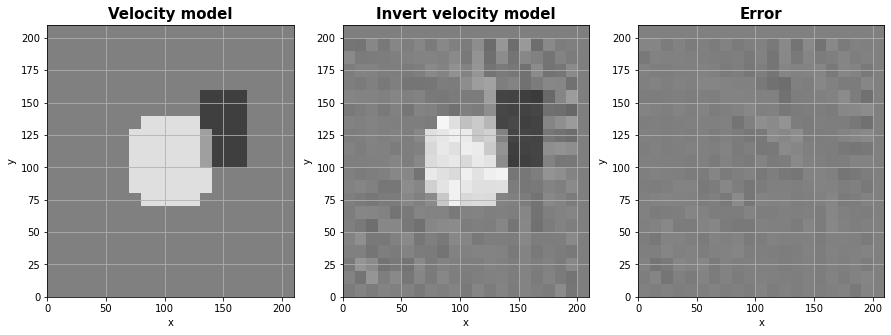

In [17]:
# Create slowness model and compute traveltime from equation 2
slown = (1. / vel).ravel()
trav = np.array(L.todense()) @ slown

# Invert slowness model
slowninv = lsqr(L, trav, x0=(1./vback) * np.ones(nx*nz), damp=1e-3, iter_lim=100)[0]
vinv = 1. / (slowninv.reshape(nx, nz) + 1e-10)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(vel.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Velocity model', fontsize=15, fontweight='bold')
axs[0].grid('on', which='both')
axs[0].axis('tight')

axs[1].imshow(vinv.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Invert velocity model', fontsize=15, fontweight='bold')
axs[1].grid('on', which='both')
axs[1].axis('tight')

axs[2].imshow(vel.T - vinv.T, cmap='gray', origin='lower', vmin=-4000, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Error', fontsize=15, fontweight='bold')
axs[2].grid('on', which='both')
axs[2].axis('tight');

We can observe how the inversion has been pretty successful in reconstructing the velocity model. However, due to the ill-posed nature of the problem, we observe some high-frequency noise popping up in the solution

We can try to mitigate this by adding some regularization. To do so we will once again take advantage of the highly-efficient matrix free optimization implementation of regularized inverse problems available in PyLops.

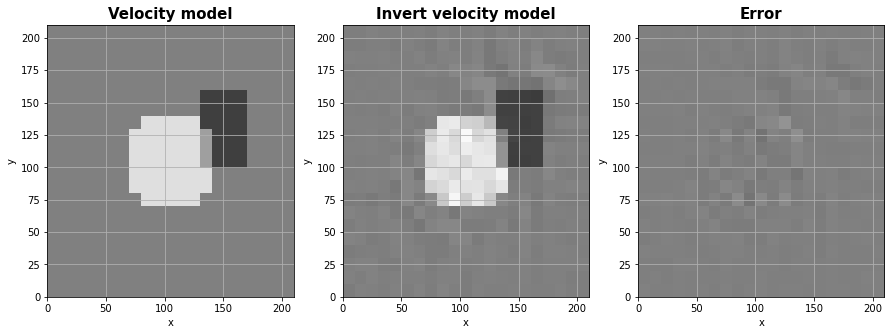

In [18]:
# Invert slowness model
Dop = pylops.Laplacian((nx, nz))

slowninv = pylops.optimization.leastsquares.RegularizedInversion(pylops.MatrixMult(L), 
                                                                 [Dop,], trav, epsRs=[5e-1,], 
                                                                 x0=(1./vback) * np.ones(nx*nz), 
                                                                 **dict(iter_lim=100, damp=1e-1))
vinv = 1. / (slowninv.reshape(nx, nz) + 1e-10)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(vel.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Velocity model', fontsize=15, fontweight='bold')
axs[0].grid('on', which='both')
axs[0].axis('tight')

axs[1].imshow(vinv.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Invert velocity model', fontsize=15, fontweight='bold')
axs[1].grid('on', which='both')
axs[1].axis('tight')

axs[2].imshow(vel.T - vinv.T, cmap='gray', origin='lower', vmin=-4000, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Error', fontsize=15, fontweight='bold')
axs[2].grid('on', which='both')
axs[2].axis('tight');

## Noisy inversion

Finally we experiment with noisy data. In real life traveltimes will never be provided directly to us, rather the may be estimated from seismic recordings. It is therefore logical to expect them to be affected by some noise.

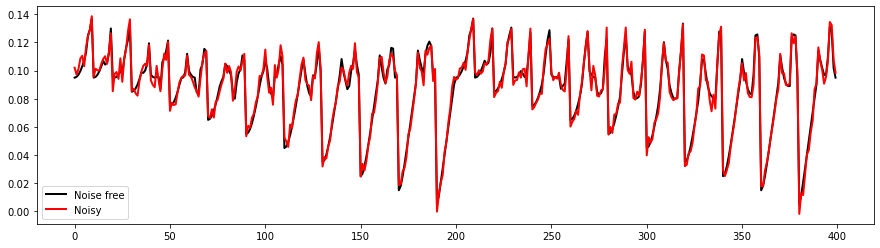

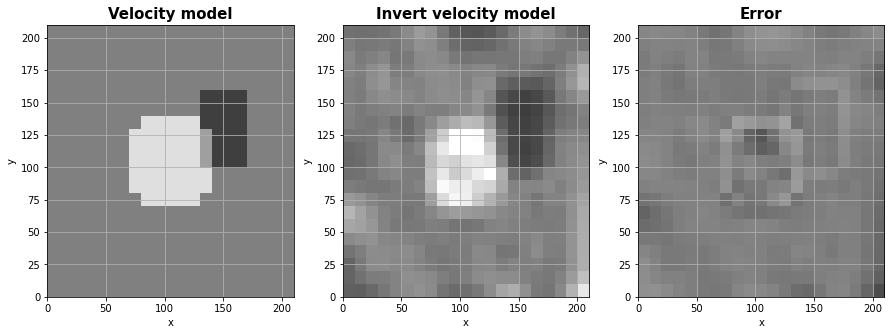

In [19]:
travn = trav + 4e-3*np.random.normal(0., 1., ns*nr)

plt.figure(figsize=(15, 4))
plt.plot(trav, 'k', lw=2, label='Noise free')
plt.plot(travn, 'r', lw=2, label='Noisy')
plt.legend()

Dop = pylops.Laplacian((nx, nz))

slowninv = pylops.optimization.leastsquares.RegularizedInversion(pylops.MatrixMult(L), 
                                                                 [Dop,], travn, epsRs=[2e1,], 
                                                                 x0=(1./vback) * np.ones(nx*nz), 
                                                                 **dict(iter_lim=100, damp=1e-1))
vinv = 1. / (slowninv.reshape(nx, nz) + 1e-10)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(vel.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Velocity model', fontsize=15, fontweight='bold')
axs[0].grid('on', which='both')
axs[0].axis('tight')

axs[1].imshow(vinv.T, cmap='gray', origin='lower', vmin=0, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Invert velocity model', fontsize=15, fontweight='bold')
axs[1].grid('on', which='both')
axs[1].axis('tight')

axs[2].imshow(vel.T - vinv.T, cmap='gray', origin='lower', vmin=-4000, vmax=4000,
            extent=(x[0]-dx//2, x[-1]+dx//2, z[0]-dz//2, z[-1]+dz//2))
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Error', fontsize=15, fontweight='bold')
axs[2].grid('on', which='both')
axs[2].axis('tight');